In [1]:
import os
import cv2
import pytorch
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import torchvision.transforms.functional as F
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from torchvision.transforms import ToTensor
import imageio

# 1. Build Data Loading Functions

In [5]:
import gdown

In [6]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=bd1621e8-1992-468e-9765-ca5d91940e76
To: /content/data.zip
100%|██████████| 423M/423M [00:06<00:00, 65.1MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [7]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = F.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = torch.mean(frames.float())
    std = torch.std(frames.float())
    normalized_frames = (frames.float() - mean) / std
    return normalized_frames

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)


# Create char_to_num mapping (StringLookup equivalent)
char_to_num = {char: idx for idx, char in enumerate(vocab)}
char_to_num[""] = len(vocab)  # Add mapping for out-of-vocabulary token

# Create num_to_char mapping (StringLookup with invert=True equivalent)
num_to_char = {idx: char for char, idx in char_to_num.items()}

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [11]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [12]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [13]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return [char_to_num[char] for token in tokens for char in token][1:]

In [14]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]

    print(file_name)
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [15]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [16]:
test_filename = os.path.splitext(os.path.basename(test_path.replace('\\', '/')))[0]

'bbal6n'

In [ ]:
def load_data(test_path):
    # Assuming 'test_path' is a string representing the file path to an image or data file
    
    # Load data using standard Python file loading (e.g., loading an image)
    image = Image.open(test_path)  # Load the image using PIL (Python Imaging Library)

    # Perform any necessary preprocessing on the loaded data (e.g., image preprocessing)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
        # Add more preprocessing transformations as needed
    ])
    processed_image = transform(image)  # Apply transformations to the image

    # Example: If 'alignments' are not applicable in this context, return None for alignments
    alignments = None

    return processed_image, alignments

frames, alignments = load_data(test_path)


In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

In [ ]:
# Convert PyTorch tensor to a list of characters using num_to_char mapping
char_list = [num_to_char[idx.item()] for idx in alignments]
joined_string = ''.join(char_list)

In [18]:
def load_data_pytorch(path: str) -> (torch.Tensor, torch.Tensor):
    # Define your data loading and preprocessing logic using PyTorch
    image = Image.open(path).convert('RGB')  # Load image and convert to RGB format

    # Define a series of preprocessing transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to (224, 224)
        transforms.ToTensor(),           # Convert PIL image to PyTorch tensor (float32, normalized)
    ])
    processed_image = transform(image)  # Apply transformations to the image

    # Dummy output for alignments (torch.Tensor of indices, example)
    alignments = torch.tensor([1, 2, 3])  # Replace with actual alignment data if needed

    return processed_image, alignments

def mappable_function(path: str) -> List[str]:
    # Call the load_data_pytorch function to load and preprocess data
    frames, alignments = load_data_pytorch(path)

    # Convert PyTorch tensor data types to list of strings (for demonstration)
    result_frames = frames.tolist()  # Convert frames tensor to list of floats
    result_alignments = alignments.tolist()  # Convert alignments tensor to list of ints

    # Example: Convert list of floats/ints to list of strings (for demonstration)
    result_frames_str = [str(item) for item in result_frames]
    result_alignments_str = [str(item) for item in result_alignments]

    # Combine and return the result as a list of strings
    result = result_frames_str + result_alignments_str
    return result


# 2. Create Data Pipeline

In [19]:
from matplotlib import pyplot as plt

In [20]:
data = torch.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
# # Added for split
train = data.take(450)
test = data.skip(450)

In [21]:
frames, alignments = data.as_numpy_iterator().next()

brbtzn
sbig4n
sgic1a


In [22]:
len(frames)

2

In [23]:
sample = data.as_numpy_iterator()

In [24]:
val = sample.next(); val[0]

lgas3s
swbv5a
lbby3s


array([[[[[ 1.0971233 ],
          [ 1.1363063 ],
          [ 0.74447656],
          ...,
          [ 0.3134638 ],
          [ 0.27428082],
          [ 0.27428082]],

         [[ 1.1363063 ],
          [ 1.1363063 ],
          [ 0.4701957 ],
          ...,
          [ 0.3134638 ],
          [ 0.27428082],
          [ 0.27428082]],

         [[ 1.4889531 ],
          [ 1.4889531 ],
          [ 1.2146722 ],
          ...,
          [ 0.3134638 ],
          [ 0.27428082],
          [ 0.27428082]],

         ...,

         [[ 1.0971233 ],
          [ 1.0971233 ],
          [ 1.0971233 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.0579404 ],
          [ 1.0579404 ],
          [ 1.0579404 ],
          ...,
          [ 9.991659  ],
          [ 9.991659  ],
          [ 9.991659  ]],

         [[ 1.0579404 ],
          [ 1.0579404 ],
          [ 1.0579404 ],
          ...,
          [ 9.991659  ],
          [ 9.991659  ],
          

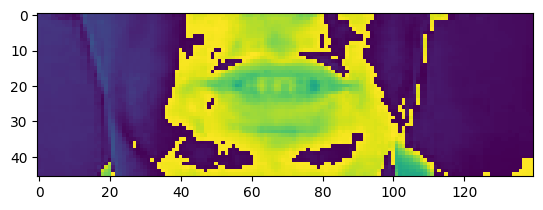

In [25]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

# 3. Design the Deep Neural Network

In [28]:
data.as_numpy_iterator().next()[0][0].shape

pwip8p
sria8p


(75, 46, 140, 1)

In [29]:
import torch
import torch.nn as nn

class Conv3DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super(Conv3DBlock, self).__init__()
        self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding)
        self.activation = nn.ReLU()
        self.maxpool3d = nn.MaxPool3d(kernel_size=(1, 2, 2))

    def forward(self, x):
        x = self.conv3d(x)
        x = self.activation(x)
        x = self.maxpool3d(x)
        return x

class CustomModel(nn.Module):
    def __init__(self, vocab_size):
        super(CustomModel, self).__init__()

        self.conv_block1 = Conv3DBlock(in_channels=1, out_channels=128, kernel_size=3, padding='same')
        self.conv_block2 = Conv3DBlock(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.conv_block3 = Conv3DBlock(in_channels=256, out_channels=75, kernel_size=3, padding='same')

        self.flatten = nn.Flatten()
        self.time_distributed = nn.Sequential(
            nn.Linear(75 * 12 * 35, 75 * 12 * 35),  # Assuming input size after Conv3D is (75, 12, 35)
            nn.ReLU()
        )

        self.lstm1 = nn.LSTM(input_size=75 * 12 * 35, hidden_size=128, bidirectional=True, batch_first=True)
        self.dropout1 = nn.Dropout(p=0.5)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=128, bidirectional=True, batch_first=True)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc = nn.Linear(256, vocab_size + 1)  # Output size = vocabulary size + 1 (for out-of-vocabulary token)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = self.flatten(x)
        x = self.time_distributed(x)

        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)

        x = self.fc(x)
        return x

vocab_size = char_to_num.vocabulary_size()
model = CustomModel(vocab_size)

# Example input shape (batch_size, channels, depth, height, width)
input_shape = (1, 1, 75, 46, 140)
input_tensor = torch.randn(input_shape)

# Forward pass through the model
output = model(input_tensor)


In [32]:
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [35]:
model.input_shape

(None, 75, 46, 140, 1)

In [36]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [37]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [38]:
def CTCLoss(y_true, y_pred):
    # Convert y_true and y_pred to appropriate format for CTC loss
    # y_true: List of tensors containing the target transcription indices (batch_size, max_target_length)
    # y_pred: Tensor containing the predicted logits (batch_size, max_input_length, num_classes)

    batch_size = y_pred.shape[0]
    input_lengths = torch.full((batch_size,), y_pred.shape[1], dtype=torch.long)
    target_lengths = torch.full((batch_size,), y_true.shape[1], dtype=torch.long)

    # PyTorch's CTCLoss function expects input_lengths and target_lengths as arguments
    ctc_loss = torch.nn.CTCLoss(blank=0)  # Initialize CTC loss with blank label as 0
    loss = ctc_loss(y_pred, y_true, input_lengths, target_lengths)

    return loss

In [39]:
class ProduceExample:
    def __init__(self, dataset_loader, model, num_to_char) -> None:
        self.dataset_loader = dataset_loader
        self.model = model
        self.num_to_char = num_to_char

    def on_epoch_end(self, epoch) -> None:
        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for data in self.dataset_loader:
                inputs, targets = data
                outputs = self.model(inputs)  # Forward pass to get model predictions

                # Perform CTC decoding
                decoded, _ = torch.nn.CTCLoss._ctc_decode(outputs.permute(1, 0, 2), torch.tensor([75, 75]), greedy=False)
                decoded = decoded[0].numpy()

                # Iterate over batch examples and print original vs. predicted sequences
                for x in range(len(outputs)):
                    original = ''.join([self.num_to_char[idx] for idx in targets[x]])
                    predicted = ''.join([self.num_to_char[idx] for idx in decoded[x]])

                    print('Original:', original)
                    print('Prediction:', predicted)
                    print('~' * 100)

# Example usage:
from torch.utils.data import DataLoader

# Instantiate ProduceExample callback
produce_example_callback = ProduceExample(dataset_loader, model, num_to_char)

# Example: Call on_epoch_end method at the end of each epoch
for epoch in range(num_epochs):
    produce_example_callback.on_epoch_end(epoch)


In [41]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [42]:
schedule_callback = LearningRateScheduler(scheduler)

In [43]:
example_callback = ProduceExample(test)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define your loss function
criterion = nn.CrossEntropyLoss()

In [46]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    # Perform validation at the end of each epoch
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        total_correct = 0
        total_examples = 0
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()
            total_examples += targets.size(0)
        
        accuracy = total_correct / total_examples

    # Execute custom callbacks at the end of each epoch
    example_callback.on_epoch_end()

bwbn2n
lgil4n
bbaz4n
  1/450 [..............................] - ETA: 7:44 - loss: 73.8255bbwtzp
pgbr2p
  2/450 [..............................] - ETA: 7:09 - loss: 77.7814pgwe9a
brwn3a
  3/450 [..............................] - ETA: 7:31 - loss: 79.3169bwwu3a
lgbm3s
  4/450 [..............................] - ETA: 10:14 - loss: 81.2056pbav3s
bwim7a
  5/450 [..............................] - ETA: 11:04 - loss: 81.6365lwiy7s
swaizn
  6/450 [..............................] - ETA: 10:14 - loss: 81.2755pwbk1s
sbbh2n
  7/450 [..............................] - ETA: 9:42 - loss: 80.9374 lwbf4p
swavzp
  8/450 [..............................] - ETA: 9:19 - loss: 80.7108sbbh4p
bgwu8p
  9/450 [..............................] - ETA: 9:01 - loss: 80.7823bbwg1s
pbbc6p
 10/450 [..............................] - ETA: 8:47 - loss: 81.5622pgaq7s
srwi4p
 11/450 [..............................] - ETA: 8:35 - loss: 82.0770sbba8n
lrarzn
 12/450 [..............................] - ETA: 8:25 - loss: 81.6528lwbl8

# 5. Make a Prediction

In [47]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=ca032212-a5ae-4cd1-acee-883a54fc47ae
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 49.7MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 973ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[pytorch.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

In [ ]:
decoded = pytorch.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]